In [1]:
import pandas as pd
import numpy as np
import torch 
import matplotlib.pyplot as plt
import os

In [2]:
'''ctr=0
Alldata=pd.DataFrame()
for maxenergy in os.listdir('Allspecs/')[-6:]:
    path='Allspecs/'+maxenergy +'/'
    for filename in os.listdir(path):
        _,el1,size,el2=filename.split('_')
        el2=el2[:-4]
        size=float(size[:-2])
        name=str((el1,el2,size,maxenergy))
        singledata=pd.read_csv(path+ filename,sep=' ',names=['E',name])
        Alldata=pd.concat([Alldata,singledata[name]],axis=1)
        #Alldata[str((maxenergy,el1,el2,size))]=singledata['I']
        #ctr=ctr+1
    print (maxenergy)'''

"ctr=0\nAlldata=pd.DataFrame()\nfor maxenergy in os.listdir('Allspecs/')[-6:]:\n    path='Allspecs/'+maxenergy +'/'\n    for filename in os.listdir(path):\n        _,el1,size,el2=filename.split('_')\n        el2=el2[:-4]\n        size=float(size[:-2])\n        name=str((el1,el2,size,maxenergy))\n        singledata=pd.read_csv(path+ filename,sep=' ',names=['E',name])\n        Alldata=pd.concat([Alldata,singledata[name]],axis=1)\n        #Alldata[str((maxenergy,el1,el2,size))]=singledata['I']\n        #ctr=ctr+1\n    print (maxenergy)"

In [3]:
Alldata=pd.read_pickle('allspecs.pkl')
Alldata=Alldata[9:]
Alldata=Alldata/Alldata.sum(0)
Alldata['E']=Alldata.index+1
Alldata=Alldata.copy()

C:\Users\anona\AppData\Local\Temp\ipykernel_11388\3221147074.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Alldata['E']=Alldata.index+1


In [4]:
Alldata

,"('Al', 'Ag', 0.0, '100')","('Al', 'Cu', 0.0, '100')","('Al', 'Mo', 0.0, '100')","('Al', 'Pd', 0.0, '100')","('Al', 'Rh', 0.0, '100')","('Al', 'W', 0.0, '100')","('Al', 'Ag', 0.01, '100')","('Al', 'Cu', 0.01, '100')","('Al', 'Mo', 0.01, '100')","('Al', 'Pd', 0.01, '100')",...,"('Al', 'Pd', 4.99, '95')","('Al', 'Rh', 4.99, '95')","('Al', 'W', 4.99, '95')","('Al', 'Ag', 5.0, '95')","('Al', 'Cu', 5.0, '95')","('Al', 'Mo', 5.0, '95')","('Al', 'Pd', 5.0, '95')","('Al', 'Rh', 5.0, '95')","('Al', 'W', 5.0, '95')",E
9,0.007523,0.006881,0.009562,0.007486,0.007735,0.128561,0.004008,0.003582,0.005303,0.004006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
10,0.009120,0.008221,0.011499,0.009124,0.009468,0.022806,0.005770,0.005082,0.007575,0.005798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
11,0.010851,0.009686,0.013539,0.010743,0.011083,0.015354,0.007733,0.006743,0.010045,0.007690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
12,0.012550,0.011141,0.015360,0.012336,0.012766,0.013157,0.009727,0.008437,0.012395,0.009603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
13,0.014036,0.012454,0.017009,0.014042,0.014576,0.014466,0.011610,0.010066,0.014648,0.011666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,246
246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247
247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248
248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249


In [5]:
monochromatic=pd.read_excel('Глубинные распределения.Вода.xlsx',header=1,skiprows=[0,1,1004,1005,1006],names=['N']+[str((a+10)) for a in range(241)])
monochromaticnorm=monochromatic/monochromatic.sum(0)
monochromaticnorm['N']=monochromatic['N']

In [5]:
distributions=(np.array(monochromaticnorm[monochromaticnorm.columns[1:]])@np.array(Alldata.fillna(0))[:,:-1]).T
specs=np.array(Alldata[Alldata.columns[:-1]].fillna(0.0)).T
basis=np.array(monochromaticnorm[monochromaticnorm.columns[1:]])
basis=torch.tensor(basis).cuda()

In [20]:
class Dosedistr(torch.nn.Module):
    def __init__(self, N_inputs=51561):
        super().__init__()
        self.specs=torch.nn.parameter.Parameter(data=torch.rand(241,N_inputs)/100, requires_grad=True)
    def forward(self, basis):
        outs=basis@self.specs
        return outs.T

In [21]:
def trainstep(model,basis,target, optimizer,lossfn=torch.nn.MSELoss()):
    optimizer.zero_grad()
    out=model(basis)
    l2_reg=0
    #model.spectrum.weight.data[:,:,:]=model.spectrum.weight.data[:,:,:]/model.spectrum.weight.data[:,:,:].sum(1,keepdim=True)
    #for param in model.parameters():
    gradx=(model.specs[1:-1,:]-model.specs.roll(1,-2)[1:-1,:])*1
    l2_smooth = gradx.square().mean()
    loss=(lossfn(out, target)*10000+l2_smooth*1000)*target.shape[0]
    #lossfn(out, target)*10000+l2_smooth
    loss.backward()
    optimizer.step()
    for p in model.parameters():
        p.data.clamp_(0)
    return loss

In [15]:
distributions.shape

(51561, 1000)

In [16]:
device='cuda'
dose=Dosedistr(51561).to(float).to(device)
dose.train()

Dosedistr()

In [31]:
lossesADAM=[]
optimizerADAM=torch.optim.Adam(dose.parameters(), lr=0.0001)
for i in range(10900):
    #print(i)
    if i%100==51:
        continue
        lossesADAM.append(loss.detach().cpu().numpy())
    loss=trainstep(dose, basis.to(device),torch.tensor(distributions).to(device),optimizerADAM,lossfn=torch.nn.L1Loss())
    if i%100==0:
        print(i,loss,dose.specs[0][0])
    if i<-2000 and i%200==1:
        dose.specs.data=dose.specs.data+torch.rand(dose.specs.data.shape).to(device)*0.01
outs[number]=dose.specs.data.cpu().detach().numpy()

0 tensor(1155.3217, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0050, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)


KeyboardInterrupt: 

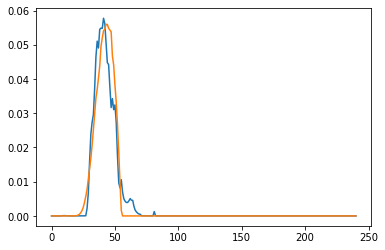

In [32]:
NUM=30000
plt.plot(dose.specs[:,NUM].cpu().detach())
plt.plot(specs[NUM,:])

In [33]:
#np.save('roughrestoredspecs.npy',dose.specs.data.cpu().detach().numpy())

In [11]:
specsrestored=np.load('roughrestoredspecs3.npy')

In [23]:
set([col.split(',')[1][2:-1] for col in Alldata.columns[:-1]])

{'Ag', 'Cu', 'Mo', 'Pd', 'Rh', 'W'}

In [10]:
for i in range(10):
    plt.plot(Als[Als.columns[i*123]])

NameError: name 'Als' is not defined

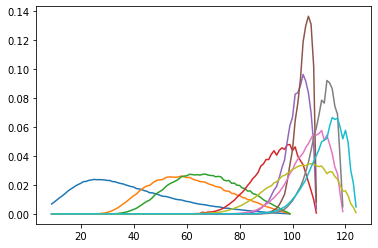

In [11]:
for i in range(10):
    plt.plot(Cus[Cus.columns[i*200]])

In [8]:
class ElementClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=torch.nn.Conv1d(1,32,3,padding=1)
        self.bn1=torch.nn.BatchNorm1d(32)
        self.conv2=torch.nn.Conv1d(32,1,3,padding=1)
        self.bn2=torch.nn.BatchNorm1d(1)
        self.classifier=torch.nn.Linear(1000,7)
        self.linear=torch.nn.Linear(1000,1000)
        self.activation=torch.nn.functional.elu
    def forward(self,x):
        b,c,l=x.shape
        y=self.bn1(self.activation(self.conv1(x)))
        y=self.bn2(self.activation(self.conv2(y)))
        y=self.activation(self.linear(y.reshape(b,-1)))
        y=self.classifier(y)
        return y.softmax(1)

In [25]:
def trainstepClass(model,inps,targets, optimizer,lossfn=torch.nn.CrossEntropyLoss()):
    optimizer.zero_grad()
    out=model(inps)
    loss=lossfn(out, targets)
    loss.backward()
    optimizer.step()
    onehot=torch.nn.functional.one_hot(out.argmax(-1),num_classes=7)
    #print(onehot.shape, targets.shape)
    #print((out).mean(0),targets.mean(0))
    acc=(onehot*targets).sum(0).sum(0)/targets.shape[0]
    #mean=one
    return loss,acc#,mean

In [10]:
classifier=torch.load('classifier.pt').cuda()

In [ ]:
#classifier=ElementClassifier().to(float).cuda()
optimizer=torch.optim.Adam(classifier.parameters(),lr=0.0001)
lossfn=torch.nn.CrossEntropyLoss()
#inps=specsrestored
inps=distributions.T
inps=torch.tensor(inps.T).unsqueeze(1).to(float).cuda()#[:10000]
targlist=[(col.split(',')[0][2:-1],col.split(',')[1][2:-1]) for col in Alldata.columns[:-1]]#[:10000]
encoder={}
decoder={}
for i,k in enumerate(set(targlist)):
    encoder[k]=i
    decoder[i]=k
targs=torch.nn.functional.one_hot(torch.tensor([encoder[targ] for targ in targlist])).to(float).cuda()
dataset = torch.utils.data.TensorDataset(inps, targs)
train,test=torch.utils.data.random_split(dataset,[51561-2048,2048])
loader=torch.utils.data.DataLoader(train, batch_size=2048, shuffle=True)
losses=[]
for epoch in range(100):
    for i,batch in enumerate(loader):
        inp,targ=batch
        #A=i%25
        #A=0
        #inp,targ=inps[A*2000:A*2000+2000],targs[A*2000:A*2000+2000]
        loss,acc=trainstepClass(classifier,inp*100,targ,optimizer)
        print(loss,acc.cpu().numpy(),epoch,i)
        if i%100==0:
            losses.append(loss.detach().cpu().numpy())
    with torch.no_grad():
        Ans=classifier(test[:][0]*100)
        acc=(Ans.argmax(1)==test[:][1].argmax(1)).sum()/len(test)
        print('val_acc' ,acc.cpu().numpy(),epoch)

tensor(1.6510, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.556640625 0 0
tensor(1.7276, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.4228515625 0 1
tensor(1.6966, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.466796875 0 2
tensor(1.6775, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.48681640625 0 3
tensor(1.6934, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.45751953125 0 4
tensor(1.6879, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.47021484375 0 5
tensor(1.6736, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.5087890625 0 6
tensor(1.6695, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.50537109375 0 7
tensor(1.6624, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.517578125 0 8


In [48]:
ansrs=[]
with torch.no_grad():
    for i in range(1):
        Ans=classifier(train[:][0][1024*i:1024*(i+1)]*100).argmax(1)
        ansrs=ansrs+list(Ans.cpu().numpy())
        print(i)

0


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [51]:
cm=confusion_matrix(ansrs, train[:][1][:len(ansrs)].argmax(1).cpu())

In [24]:
y_pred=np.load('pred.npy')
y_true=np.load('true.npy')

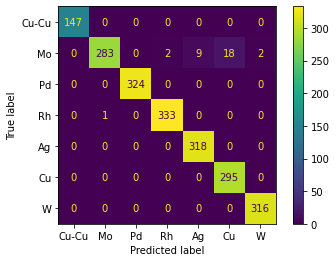

In [25]:
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_true, 
                                        display_labels=['Cu-Cu','Mo','Pd','Rh','Ag','Cu','W'])

In [7]:
import numpy as np
losses=np.load('losses.npy')
accs=np.load('accs.npy')
vallosses=np.load('vallosses.npy')
valaccs=np.load('valaccs.npy')

In [8]:
class NeuralFixer(torch.nn.Module):
    def __init__(self, in_channels=1):
        super(NeuralFixer, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels, 8, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv1d(8, 2, kernel_size=3, padding=1)
        # Layer 2
        self.conv3 = torch.nn.Conv1d(2, 241, kernel_size=241, padding=0,bias=True)
        self.relu =torch.nn.functional.relu
        self.tanh=torch.nn.functional.tanh
    def forward(self, z):
        B,C,W=z.shape
        #x = self.relu(self.adapt_nn(z)).cuda()
        #x = x.view(x.size(0), self.in_channels, self.length // 2 // 2 // 2)
        x = self.relu(self.conv1(z))
        x = self.relu(self.conv2(x))
        x = self.tanh(self.conv3(x))
        out =x.reshape(B,-1)
        return out
def trainstepfixer(model,inp,target, optimizer,lossfn=torch.nn.L1Loss()):
    optimizer.zero_grad()
    out=model(inp)
    loss=lossfn(out, target)*100
    loss.backward()
    optimizer.step()    
    return loss

In [12]:
Alldata=Alldata.fillna(0)
diff=torch.tensor(np.array(Alldata)[:,:-1]-specsrestored)

C:\Users\anona\AppData\Local\Temp\ipykernel_11388\3846084267.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targchunk=torch.tensor(diff[:,predsall==i].T*10).to(float)[:SPL]#.cuda()
C:\Users\anona\AppData\Local\Temp\ipykernel_11388\3846084267.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targval=torch.tensor(diff[:,predsall==i].T*10).to(float)[SPL:]


tensor(7.8675, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(4.3629, dtype=torch.float64) 10
tensor(2.7808, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(3.7980, dtype=torch.float64) 10
tensor(1.7470, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(4.1190, dtype=torch.float64) 10
tensor(1.4028, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(4.0521, dtype=torch.float64) 10
tensor(1.3107, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(4.0204, dtype=torch.float64) 10
tensor(1.2215, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(4.0255, dtype=torch.float64) 10
tensor(1.1802, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(4.0627, dtype=torch.float64) 10
tensor(1.1562, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(4.0604, dtype=torch.float64) 10
tensor(1.1324, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(4.0618, dtype=torch.float64) 10
tensor(1.1283, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(4.0780, dtype=torch.float64) 10
tensor(2.8

Text(0, 0.5, 'L1 * 100')

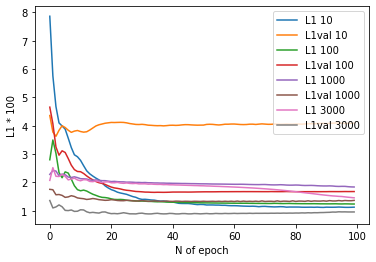

In [27]:
predsall=np.load('predsall.npy')
alldata=np.array(Alldata)[:,:-1]
nfixers=[NeuralFixer().to(float) for i in range(7)]
for SPL in [10,100,1000,3000]:
    lossesval=[]
    losses=[]
    for i in [2]:
        inpchunk=torch.tensor(specsrestored[:,predsall==i].T*10).unsqueeze(1).to(float)[:SPL]#.cuda()
        targchunk=torch.tensor(diff[:,predsall==i].T*10).to(float)[:SPL]#.cuda()
        valch=torch.tensor(specsrestored[:,predsall==i].T*10).unsqueeze(1).to(float)[SPL:]
        targval=torch.tensor(diff[:,predsall==i].T*10).to(float)[SPL:]
        optimizer=torch.optim.Adam(nfixers[i].parameters())
        for ctr in range(100):
            loss=trainstepfixer(nfixers[i],inpchunk,targchunk,optimizer)
            with torch.no_grad():
                lossval=torch.nn.L1Loss()(nfixers[i](valch),targval)*100
            if ctr%10==0:
                print(loss,lossval, SPL)
            losses.append(loss.detach().numpy())
            lossesval.append(lossval.detach().numpy())
        plt.plot(losses,label='L1 {}'.format(SPL))
        plt.plot(lossesval,label='L1val {}'.format(SPL))
plt.legend()
plt.xlabel('N of epoch')
plt.ylabel('L1 * 100')

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

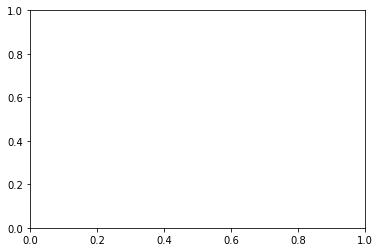

In [26]:
plt.plot(loss)

In [134]:
with torch.no_grad():
    corrected=specsrestored.T.copy()*10
    for i in range(7):
        chunk=torch.tensor(corrected[predsall==i,:]).unsqueeze(1)
        corrected[predsall==i,:]=corrected[predsall==i,:]+nfixers[i](chunk).numpy()

In [166]:
for i, model in enumerate(nfixers):
    torch.save('correctormodel_{}.pt'.format(encoder[i]),model)

NameError: name 'encoder' is not defined

In [167]:
np.abs((specsrestored-alldata)).mean()

NameError: name 'encoders' is not defined

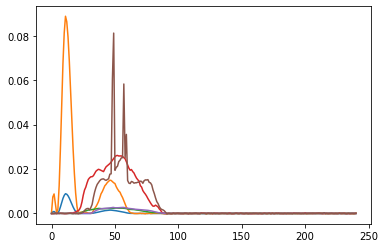

In [198]:
for j in range(3):
    plt.plot(specsrestored.T[1000*j+15]/10)
    plt.plot(corrected[1000*j+15]/10)

In [161]:
np.abs((specsrestored-alldata)).mean()

0.0011665169573828633

In [173]:
np.abs((corrected.T/10-alldata)).std()

0.005986199901548474

In [163]:
np.abs((corrected.T/10-alldata)).mean()

0.0009525838150694399